# Functions

## model/data_setup

In [1]:
%%writefile model/data_setup.py
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from pathlib import Path
"""
Contain for setting updata with full func to create dataloader
"""

def create_dataloader(
                    train_transform: transforms.Compose,
                    val_transform: transforms.Compose,
                    test_transform: transforms.Compose,
                    **kwargs,
                ):
    
    train_path = Path(kwargs['dataset']['train'])
    val_path = Path(kwargs['dataset']['val'])
    test_path = Path(kwargs['dataset']['test'])
    
    num_workers = 6
    
    train_data = ImageFolder(
        root= train_path,
        transform= train_transform
    )
    
    val_data = ImageFolder(
        root= val_path,
        transform= val_transform
    )

    test_data = ImageFolder(
        root= test_path,
        transform= test_transform
    )
    
    train_dataloader = DataLoader(
        dataset= train_data,
        batch_size= kwargs['dataset']['batch_size'],
        num_workers=num_workers,
        pin_memory= True,
        persistent_workers= True,
        shuffle= True
    )
    
    val_dataloader = DataLoader(
        dataset= val_data,
        batch_size= kwargs['dataset']['batch_size'],
        num_workers=num_workers,
        pin_memory= True,
        persistent_workers= True,
        shuffle= False
    )

    test_dataloader = DataLoader(
        dataset= test_data,
        batch_size= kwargs['dataset']['batch_size'],
        shuffle= False
    )
    class_names = train_data.classes
    return train_dataloader, val_dataloader, test_dataloader, class_names

Overwriting model/data_setup.py


## model/model_builder

In [2]:
%%writefile model/model_builder.py
import torch
from torch import nn
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import vgg19, VGG19_Weights
from torchvision.models import vgg16, VGG16_Weights

from pathlib import Path
import json

def load_model(model_name: str=None, class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    
    if pretrain_model_path is not None:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)

        class_names = info_data['class_names']
        model_name = info_data['model']
        
    if model_name == 'resnet50':
        weights = ResNet50_Weights.DEFAULT
        model = resnet50(weights= weights).to(device)
        
        features= model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
    elif model_name == 'resnet18':
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights= weights).to(device)
        
        features= model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
    elif model_name == 'vgg19':
        weights = VGG19_Weights.DEFAULT
        model = vgg19(weights= weights).to(device)
        
        features= model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
    elif model_name == 'vgg16':
        weights = VGG16_Weights.DEFAULT
        model = vgg16(weights= weights).to(device)
        
        features= model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
    elif model_name == 'effi_net_v2_s':
        weights = EfficientNet_V2_S_Weights.DEFAULT
        model = efficientnet_v2_s(weights= weights).to(device)
        
        features= model.classifier[-1].in_features
        model.classifier[-1] = nn.Sequential(
            nn.Linear(in_features=features, out_features=len(class_names), bias=True)
        )
        
    if pretrain_model_path is not None:
        model.load_state_dict(torch.load(f=pretrain_model_path / f'{model_name}.pth'))
            
    model = model.to(device)
            
    return model, info_data

Overwriting model/model_builder.py


## model/utils

In [3]:
%%writefile model/utils.py
import os
from pathlib import Path
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def plot_loss_curves(results: dict[str, list[float]]):
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    
    train_accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    train_precision = results['train_precision']
    val_precision = results['val_precision']
    
    train_recall = results['train_recall']
    val_recall = results['val_recall']
    
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_precision, label='train_precision')
    plt.plot(epochs, val_precision, label='val_precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_recall, label='train_recall')
    plt.plot(epochs, val_recall, label='val_recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.legend()
    return plt

def plot_confmat(class_names, test_results):
    table = confusion_matrix(y_true=test_results['targets'], y_pred=test_results['preds'])
    
    plt.figure(figsize=(7.5, 5))
    sns.heatmap(table, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    
    plt.text(x= len(class_names)*1.25, y=(len(class_names)*0.1), s= f'Class names:')
    for i, class_name in enumerate(class_names):
        plt.text(x=len(class_names)*1.25, y=(len(class_names)*0.1)+ (len(class_names)*0.05)*(i+1), s= f' {i}. {class_name[:15]}{"..." if len(class_name) > 15 else ""}')

    plt.tight_layout()
    return plt

def plot_save_model(model: torch.nn.Module,
                    model_name: str,
                    results: dict[str, list[float]],
                    class_names: list,
                    device: str,
                    is_save: bool):

    df_test_results = pd.DataFrame(results['test_results'])
    
    if is_save:
        target_dir = Path('runs/classify/')
        target_dir.mkdir(parents=True, exist_ok=True)
        
        graph_loss_name = 'loss_acc_precision_recall.jpg'
        graph_confmat_name = 'confusion_matrix.jpg'
        info_file_name = 'info.json'
        
        train_paths = os.listdir(target_dir)
        
        i = 0
        
        while True:
            train_path = f'train{i}'
            if train_path not in train_paths:
                break
            else:
                i += 1
    
        target_dir = target_dir / train_path
        
        target_dir_path = Path(target_dir)
        target_dir_path.mkdir(parents=True,exist_ok=True)
        
        model_save_path = target_dir_path / (model_name + '.pth')
        graph_loss_save_path = target_dir_path / graph_loss_name
        graph_confmat_save_path = target_dir_path / graph_confmat_name
        info_save_path = target_dir_path / info_file_name

        print(f"[INFO] Saving model to: {target_dir}")
        
        info_data = {
            'model': model_name,
            "class_names" : class_names,
            "results" : results
        }
        
        with open(info_save_path, 'w') as f:
            json.dump(info_data, f, indent=4)
    
    graph_loss = plot_loss_curves(results)
    if is_save: graph_loss.savefig(graph_loss_save_path)
        
    graph_confmat = plot_confmat(class_names=class_names, test_results= results['test_results'])
    if is_save: graph_confmat.savefig(graph_confmat_save_path)
    
    if is_save: torch.save(obj=model.state_dict(), f=model_save_path)

def save_checkpoint(model: torch.nn.Module, num: int):
    target_path = Path('runs/classify/')
    target_path.mkdir(parents=True, exist_ok=True)

    checkpoint_dir = target_path / 'checkpoints'
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    checkpoint_names = os.listdir(checkpoint_dir)
    
    checkpoint_name = f'.checkpoint_{num}.pth'

    checkpoint_path = checkpoint_dir / checkpoint_name
    torch.save(obj=model.state_dict(), f=checkpoint_path)

    print(f'Save checkpoint to {checkpoint_path}')

Overwriting model/utils.py


## model/engine

In [4]:
%%writefile model/engine.py
import torch
from torchmetrics import functional
from tqdm.auto import tqdm
from model.utils import save_checkpoint

def __train(model: torch.nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_func: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            mectric_funcs: functional,
            verbose: bool,
            device: str):
    
    train_loss = 0
    train_acc = 0
    train_precision = 0
    train_recall = 0
    
    model.train()

    for _, (X, y) in enumerate(tqdm(dataloader, desc= '-----Train', disable= (not verbose))):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_func(y_pred, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
        train_acc += mectric_funcs[0](y_pred, y).item()
        train_precision += mectric_funcs[1](y_pred, y).item()
        train_recall += mectric_funcs[2](y_pred, y).item()
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_precision /= len(dataloader)
    train_recall /= len(dataloader)
    
    return train_loss, train_acc, train_precision, train_recall

def __val(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           loss_func: torch.nn.Module,
           mectric_funcs: functional,
           verbose: bool,
           device: str):

    val_loss = 0
    val_acc = 0
    val_precision = 0
    val_recall = 0
    
    model.eval()
    
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '-------Val', disable= (not verbose))):
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            
            val_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)
            val_acc += mectric_funcs[0](y_pred, y).item()
            val_precision += mectric_funcs[1](y_pred, y).item()
            val_recall += mectric_funcs[2](y_pred, y).item()
            
        val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        val_precision /= len(dataloader)
        val_recall /= len(dataloader)
    
    return val_loss, val_acc, val_precision, val_recall

def __test(model: torch.nn.Module,
           dataloader: torch.utils.data.DataLoader,
           verbose: bool,
           device: str):
    
    model.eval()
    target = torch.tensor([]).to(device)
    preds = torch.tensor([]).to(device)
    score = torch.tensor([]).to(device)
    
    with torch.inference_mode():
        for _, (X, y) in enumerate(tqdm(dataloader, desc= '------Test', disable= (not verbose))):
            X, y = X.to(device), y.to(device)

            
            y_pred = model(X)

            y_probs = torch.softmax(y_pred, dim= 1)
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim= 1), dim= 1)

            y_pred_scores = torch.max(y_probs, dim= 1)[0]

            target = torch.cat((target, y), dim= 0)
            preds = torch.cat((preds, y_pred_class), dim= 0)
            score = torch.cat((score, y_pred_scores), dim= 0)

    test_results = {
        'preds' : preds.tolist(),
        'targets' : target.tolist(),
        'scores' : score.tolist()
    }

    return test_results

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
          mectric_funcs: list[functional],
          epochs: int,
          info_data: list,
          save_checkpoint_freq: int,
          verbose: bool,
          device: str):
    
    temp_model_state_dict = model.state_dict()
    
    if info_data is None:
        results = {
            'train_loss': [],
            'train_acc': [],
            'train_precision': [],
            'train_recall': [],
            'val_loss': [],
            'val_acc': [],
            'val_precision': [],
            'val_recall': [],
            'test_results' : {}
        }
    else:
        results = info_data['results']
    
    if epochs <= 0: return results
        
    try:
        torch.manual_seed(42) 
        torch.cuda.manual_seed(42)
        for epoch in tqdm(range(epochs), desc= 'Training', disable=(not verbose)):
            if (verbose):
                print(f"\n\nEpoch: {epoch+1:2} ------------")
            train_loss, train_acc, train_precision, train_recall = __train(model=model,
                                                                    dataloader=train_dataloader,
                                                                    loss_func=loss_func,
                                                                    optimizer=optimizer,
                                                                    mectric_funcs=mectric_funcs,
                                                                    verbose= verbose,
                                                                    device= device)
            lr_scheduler.step()
            val_loss, val_acc, val_precision, val_recall = __val(model=model,
                                                                dataloader=val_dataloader,
                                                                loss_func=loss_func,
                                                                mectric_funcs=mectric_funcs,
                                                                verbose= verbose,
                                                                device= device)
            
            # print(f"Epoch: {epoch+1:2} | Train Loss: {train_loss:.5f} | Train Acc: {train_acc*100:.4f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc*100:.4f}")
            print(f"Epoch: {epoch+1:2}" + 
                f"\n  Train: Loss: {train_loss:.5f} | Acc: {train_acc*100:.4f} | Precision: {train_precision:.4f} | Recall: {train_recall:.4f}" +
                f"\n  Val  : Loss: {val_loss:.5f} | Acc: {val_acc*100:.4f} | Precision: {val_precision:.4f} | Recall: {val_recall:.4f}")
            
            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["train_precision"].append(train_precision)
            results["train_recall"].append(train_recall)
            
            results["val_loss"].append(val_loss)
            results["val_acc"].append(val_acc)
            results["val_precision"].append(val_precision)
            results["val_recall"].append(val_recall)
    
            if (save_checkpoint_freq != 0) and ((epoch+1) % save_checkpoint_freq == 0):
                save_checkpoint(model= model, num= int((epoch+1) / save_checkpoint_freq))
                
            temp_model_state_dict = model.state_dict()
    except KeyboardInterrupt:
        print('\nStop trainning')
        model.load_state_dict(temp_model_state_dict)
   
    print('\n\n')
    
    return results
    
def test(model: torch.nn.Module,
          test_dataloader: torch.utils.data.DataLoader,
          results: dict,
          verbose: bool,
          device: str):
    
    results["test_results"] = __test(model=model,
                                     dataloader=test_dataloader,
                                     verbose= verbose,
                                     device= device)
    return results

Overwriting model/engine.py


## model/train

In [5]:
# %%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall

from model.data_setup import create_dataloader
from model.engine import train, test
from model.utils import plot_save_model
from model.model_builder import load_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    print(f"Device: '{device}'")
    
    torch.cuda.empty_cache()
    
    train_transforms_data = transforms.Compose([
        transforms.Resize(size= (224, 224)),
        # transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms.transforms.ColorJitter(brightness= [0.9, 1.1], contrast= [0.9, 1.1]),
        transforms.ToTensor(),
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= (224, 224)),
        transforms.ToTensor(),
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= (224, 224)),
        transforms.ToTensor(),
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)

    model_name = kwargs['model']
    pretrain_model_path= kwargs['train_para']['pretrain_model_path']
    model, info_data = load_model(model_name= model_name, class_names= class_names, pretrain_model_path= pretrain_model_path, device= device)
    
    loss_func = nn.CrossEntropyLoss()

    lr = kwargs['train_para']['optimize']['learning_rate']
    momentum = kwargs['train_para']['optimize']['momentum']
    weight_decay = kwargs['train_para']['optimize']['weight_decay']
    optimizer = torch.optim.SGD(params= model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    mectric_funcs = []
    mectric_funcs.append(Accuracy(task='multiclass', num_classes= len(class_names)).to(device))
    mectric_funcs.append(MulticlassPrecision(num_classes= len(class_names)).to(device))
    mectric_funcs.append(MulticlassRecall(num_classes= len(class_names)).to(device))

    step_size = kwargs['train_para']['lr_scheduler']['step_size']
    gamma = kwargs['train_para']['lr_scheduler']['gamma']
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size= step_size,
        gamma= gamma
    )

    epochs= kwargs['train_para']['epochs']
    save_checkpoint_freq= kwargs['train_para']['save_checkpoint_freq']
    verbose= kwargs['train_para']['verbose']
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            lr_scheduler= lr_scheduler,
            mectric_funcs= mectric_funcs,
            epochs= epochs,
            info_data = info_data,
            save_checkpoint_freq= save_checkpoint_freq,
            verbose= verbose,
            device= device,
    )

    results = test(model=model,
                  test_dataloader=test_dataloader,
                  results=results,
                  verbose= verbose,
                  device= device)

    is_save = True if epochs > 0 else False
    plot_save_model(
        model= model,
        model_name= model_name,
        results= results,
        class_names= class_names,
        is_save= is_save,
        device= device
    )
    
    torch.cuda.empty_cache()

# Train

Device: 'cuda'


Training:   0%|          | 0/20 [00:00<?, ?it/s]



Epoch:  1 ------------


-----Train:   0%|          | 0/250 [00:17<?, ?it/s]

-------Val:   0%|          | 0/63 [00:17<?, ?it/s]

Epoch:  1
  Train: Loss: 0.92013 | Acc: 67.0472 | Precision: 0.6548 | Recall: 0.6602
  Val  : Loss: 0.35594 | Acc: 87.7480 | Precision: 0.4613 | Recall: 0.4272
Save checkpoint to runs\classify\checkpoints\.checkpoint_1.pth


Epoch:  2 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  2
  Train: Loss: 0.35329 | Acc: 88.2363 | Precision: 0.8784 | Recall: 0.8725
  Val  : Loss: 0.19949 | Acc: 93.6508 | Precision: 0.5881 | Recall: 0.5673
Save checkpoint to runs\classify\checkpoints\.checkpoint_2.pth


Epoch:  3 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  3
  Train: Loss: 0.18592 | Acc: 93.4113 | Precision: 0.9276 | Recall: 0.9285
  Val  : Loss: 0.12905 | Acc: 95.5357 | Precision: 0.6476 | Recall: 0.6311
Save checkpoint to runs\classify\checkpoints\.checkpoint_3.pth


Epoch:  4 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  4
  Train: Loss: 0.13432 | Acc: 95.4613 | Precision: 0.9449 | Recall: 0.9444
  Val  : Loss: 0.20165 | Acc: 92.8571 | Precision: 0.5752 | Recall: 0.5502
Save checkpoint to runs\classify\checkpoints\.checkpoint_4.pth


Epoch:  5 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  5
  Train: Loss: 0.10484 | Acc: 96.3371 | Precision: 0.9618 | Recall: 0.9599
  Val  : Loss: 0.12557 | Acc: 95.4861 | Precision: 0.6774 | Recall: 0.6619
Save checkpoint to runs\classify\checkpoints\.checkpoint_5.pth


Epoch:  6 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  6
  Train: Loss: 0.08564 | Acc: 97.2367 | Precision: 0.9695 | Recall: 0.9688
  Val  : Loss: 0.18213 | Acc: 93.7996 | Precision: 0.6820 | Recall: 0.6618
Save checkpoint to runs\classify\checkpoints\.checkpoint_6.pth


Epoch:  7 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  7
  Train: Loss: 0.06223 | Acc: 97.7496 | Precision: 0.9758 | Recall: 0.9753
  Val  : Loss: 0.09664 | Acc: 96.7262 | Precision: 0.6995 | Recall: 0.6868
Save checkpoint to runs\classify\checkpoints\.checkpoint_7.pth


Epoch:  8 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  8
  Train: Loss: 0.05747 | Acc: 98.0996 | Precision: 0.9805 | Recall: 0.9805
  Val  : Loss: 0.07920 | Acc: 97.5694 | Precision: 0.7593 | Recall: 0.7499
Save checkpoint to runs\classify\checkpoints\.checkpoint_8.pth


Epoch:  9 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  9
  Train: Loss: 0.03502 | Acc: 98.8500 | Precision: 0.9861 | Recall: 0.9872
  Val  : Loss: 0.06608 | Acc: 97.9663 | Precision: 0.7720 | Recall: 0.7632
Save checkpoint to runs\classify\checkpoints\.checkpoint_9.pth


Epoch: 10 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 10
  Train: Loss: 0.03181 | Acc: 98.8996 | Precision: 0.9865 | Recall: 0.9871
  Val  : Loss: 0.10794 | Acc: 96.7262 | Precision: 0.7013 | Recall: 0.6879
Save checkpoint to runs\classify\checkpoints\.checkpoint_10.pth


Epoch: 11 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 11
  Train: Loss: 0.02540 | Acc: 99.1250 | Precision: 0.9898 | Recall: 0.9898
  Val  : Loss: 0.06110 | Acc: 98.0655 | Precision: 0.7683 | Recall: 0.7595
Save checkpoint to runs\classify\checkpoints\.checkpoint_11.pth


Epoch: 12 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 12
  Train: Loss: 0.01851 | Acc: 99.3996 | Precision: 0.9946 | Recall: 0.9936
  Val  : Loss: 0.06811 | Acc: 98.0159 | Precision: 0.7646 | Recall: 0.7557
Save checkpoint to runs\classify\checkpoints\.checkpoint_12.pth


Epoch: 13 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 13
  Train: Loss: 0.01644 | Acc: 99.4875 | Precision: 0.9939 | Recall: 0.9929
  Val  : Loss: 0.06040 | Acc: 98.2143 | Precision: 0.8003 | Recall: 0.7924
Save checkpoint to runs\classify\checkpoints\.checkpoint_13.pth


Epoch: 14 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 14
  Train: Loss: 0.01489 | Acc: 99.5746 | Precision: 0.9961 | Recall: 0.9955
  Val  : Loss: 0.06836 | Acc: 98.0159 | Precision: 0.7804 | Recall: 0.7716
Save checkpoint to runs\classify\checkpoints\.checkpoint_14.pth


Epoch: 15 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 15
  Train: Loss: 0.01155 | Acc: 99.5750 | Precision: 0.9962 | Recall: 0.9965
  Val  : Loss: 0.06698 | Acc: 97.9663 | Precision: 0.7751 | Recall: 0.7665
Save checkpoint to runs\classify\checkpoints\.checkpoint_15.pth


Epoch: 16 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 16
  Train: Loss: 0.01150 | Acc: 99.6375 | Precision: 0.9965 | Recall: 0.9962
  Val  : Loss: 0.05740 | Acc: 98.0159 | Precision: 0.7817 | Recall: 0.7730
Save checkpoint to runs\classify\checkpoints\.checkpoint_16.pth


Epoch: 17 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 17
  Train: Loss: 0.00752 | Acc: 99.8000 | Precision: 0.9977 | Recall: 0.9977
  Val  : Loss: 0.05528 | Acc: 98.3135 | Precision: 0.8108 | Recall: 0.8037
Save checkpoint to runs\classify\checkpoints\.checkpoint_17.pth


Epoch: 18 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 18
  Train: Loss: 0.00762 | Acc: 99.7625 | Precision: 0.9978 | Recall: 0.9971
  Val  : Loss: 0.06698 | Acc: 98.0655 | Precision: 0.7831 | Recall: 0.7738
Save checkpoint to runs\classify\checkpoints\.checkpoint_18.pth


Epoch: 19 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 19
  Train: Loss: 0.00850 | Acc: 99.7375 | Precision: 0.9969 | Recall: 0.9974
  Val  : Loss: 0.05264 | Acc: 98.3135 | Precision: 0.8016 | Recall: 0.7938
Save checkpoint to runs\classify\checkpoints\.checkpoint_19.pth


Epoch: 20 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 20
  Train: Loss: 0.00559 | Acc: 99.8375 | Precision: 0.9982 | Recall: 0.9989
  Val  : Loss: 0.05680 | Acc: 98.3631 | Precision: 0.7989 | Recall: 0.7916
Save checkpoint to runs\classify\checkpoints\.checkpoint_20.pth





------Test:   0%|          | 0/32 [00:00<?, ?it/s]

[INFO] Saving model to: runs\classify\train2


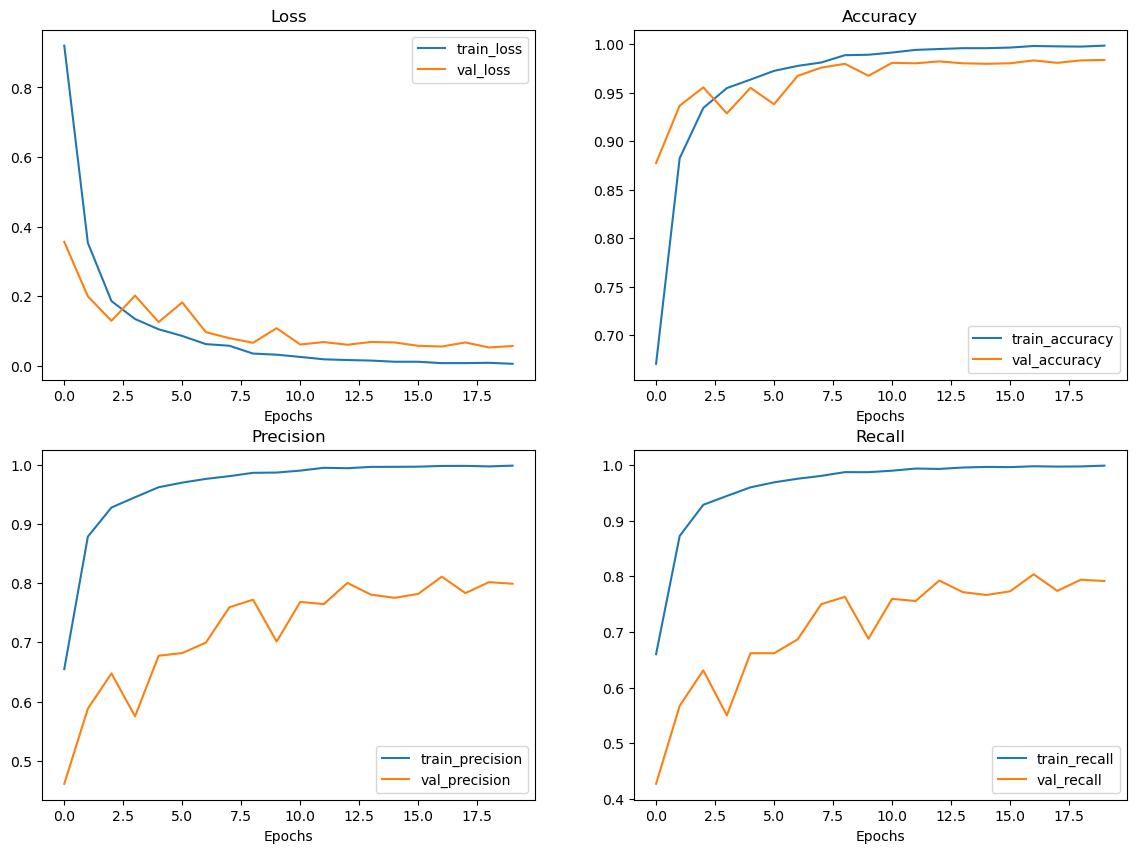

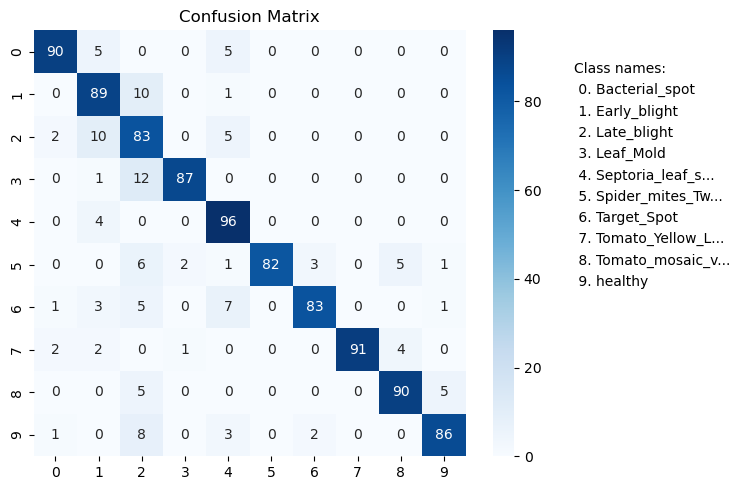

In [6]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'train': './datasets/tomato_rembg/train/',
            'val': './datasets/tomato_rembg/val/',    
            'test': './datasets/tomato_rembg/test/',
            'batch_size': 32,
        },
        'model': 'vgg16',
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 20,
            'optimize' : {
                'learning_rate': 0.002,
                'momentum': 0.9,
                'weight_decay': 0.00001,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 0.75,
            },
            'save_checkpoint_freq' : 1,
            'verbose': True
        },
    }

    # train.run(**config)
    run(**config)

In [7]:
# # from model import train

# if __name__ == '__main__':
#     config = {
#         'dataset' : {
#             'train': './datasets/tomato/train/',
#             'val': './datasets/tomato/val/',    
#             'test': './datasets/tomato/val/',
#             'batch_size': 32,
#         },
#         'model': 'effi_net_v2_s',
#         'train_para': {
#             'pretrain_model_path': './runs/classify/train6/',
#             'epochs': 0,
#             'optimize' : {
#                 'learning_rate': 0.002,
#                 'momentum': 0.9,
#                 'weight_decay': 0.00001,
#             },
#             'lr_scheduler' : {
#                 'step_size' : 2,
#                 'gamma' : 0.75,
#             },
#             'save_checkpoint_freq' : 0,
#             'verbose': True
#         },
#     }

#     # train.run(**config)
#     run(**config)